# Introduction

In this notebook, I will analyse the Seattle AirBNB Dataset from Inside AirBnb. I will follow the **CRISP-DM process** when analysing their data. The CRISP-DM stages are:

1. Business Understanding
1. Data Understanding
1. Data Preparation
1. Modelling
1. Evaluation
1. Deployment

![](../data/raw/crisp_dm_image.jpg)

# Business Understanding
    
In this project, a mail-order sales company in Germany is interested in identifying **segments of the general population to target** with their marketing in order to grow. The objective is to identify which individuals are most likely to respond to the campaign and become customers of the mail-order company.

In this section, I will first focus on identifying the parts on the population that **best describe the core customer base** of the company **using customer segmentation**.

# Data Understanding

In this step, I will focus on understanding the Arvato and Germany Demographics data. I will do this as follows:
1. Go step by step through the Data Dictionaries: [DIAS Attributes - Values 2017](../data/raw/DIAS%20Attributes%20-%20Values%202017.xlsx) and [DIAS Information Levels - Attributes 2017](../data/raw/DIAS%20Information%20Levels%20-%20Attributes%202017.xlsx) sheets.
1. Create Pandas Profiling reports and analyse them i.e. [Geramany Pop Demographics Report](../data/raw/population_demographics.html) and [Customer Demographics Report](../data/raw/customer_demographics.html)
1. Note down **observations** and **action points** from Analysis

## Load Datasets

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt

pd.set_option("display.max_columns",50)
%matplotlib inline

home_dir = '../'
data_dir = home_dir + 'data/'
raw_dir = data_dir + 'raw/'
processed_dir = data_dir + 'processed/'

In [2]:
%%time
customer_demographics = pd.read_csv(raw_dir + 'Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
population_demographics = pd.read_csv(raw_dir + 'Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

Wall time: 42.8 s


## Generate Pandas Profiling Reports

In [4]:
kwargs = dict(correlations={
        "pearson": {"calculate": False, 'warn_high_correlations': True},
        "spearman": {"calculate": False, 'warn_high_correlations': True},
        "kendall": {"calculate": False, 'warn_high_correlations': False},
        "phi_k": {"calculate": False, 'warn_high_correlations': False},
        "cramers": {"calculate": False, 'warn_high_correlations': False},
    }, missing_diagrams=None, interactions=None)

In [10]:
%%time
pp.ProfileReport(customer_demographics, title='Arvato Customer Demographics', **kwargs).to_file(raw_dir + 'customer_demographics.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 3min 34s


In [6]:
%%time
pp.ProfileReport(population_demographics, title='Germany Population Demographics', **kwargs).to_file(raw_dir + 'population_demographics.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 12min 56s


## Observations

1. The Demographics data uses **PLZ8 data**. You can find more info in it [here](https://www.regionale-marktdaten.de/plz8/) or [here](https://ddsgeo.com/download/flyer/PLZ8_eng_Flyer.pdf).
1. It also uses **grid data**. You can find more info on this dataset [here](https://www.regionale-marktdaten.de/az-deutschland-raster/).
1. It also has records of Information Level RR1_ID, RR3_ID and RR4_ID which are all different **spatial levels**. RR3_ID and RR4_ID are all associated with the **microcell level**, however I could not find a concise explanation for this spatial level beyond a small geographic area covered by a cellular carrier or some other transmission system.
1. Many features have a large proportion of unknown values i.e. -1 or 0
1. The features are too many to manually asses and drop.

## Action Points
1. Feed datasets with minimal data cleanin and transformation to algorithms to discover important features.

# Data Preparation

In this section, I clean and transform the Demographics data in preparation for clustering with HDBSCAN

In [3]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, Normalizer, LabelEncoder

In [4]:
# Identifying columns that have more than 90% nulls
proportion_missing = population_demographics.isna().sum()/population_demographics.shape[0]
missing_data_cols = proportion_missing.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Missing_Proportion'}).query("Missing_Proportion > 0.9")['index'].tolist()

customer_proportion_missing = customer_demographics.isna().sum()/customer_demographics.shape[0]
missing_data_cols_cust = customer_proportion_missing.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Missing_Proportion'}).query("Missing_Proportion > 0.9")['index'].tolist()

assert missing_data_cols == missing_data_cols_cust, "Columns missing 90% of their data in the Customer and Population dataset should be the same"

In [5]:
def clean_transform_demographics_data(demographics_df, missing_data_cols_, customer_data=True):
    """
    This method cleans and transforms the demographics data. It takes the following steps:
        1. Drop unneeded columns
        2. Peform Label Encoding on columns that represent Year and on String/Object columns
        3. Perform feature scaling on specific features
        4. Fill all nulls with -1. (This represents Unknown for most features)
        
    :param demographics_df: 
    :param missing_data_cols: Columns that have a large proportion of missing data
    :param customer_data: Boolean variable that indicates if demographics_df is customer data or population data
    :return: Transformed demographics_df, Label Encoding Dict, Scaling Dict
    """
    demographics_df = demographics_df.copy()
    
    if customer_data:
        drop_columns = ['PRODUCT_GROUP','CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    else:
        drop_columns = []
    
    # Columns missing more than 90% of their data
    drop_columns += missing_data_cols_

    # EINGEFUEGT_AM -> Inserted On (Date the record was inserted into the dataset)
    # LNR -> Record ID (Not necessary)
    # ANZ_HH_TITEL -> number of holders of an academic title in the building (Mostly 0)
    drop_columns += ['LNR', 'EINGEFUEGT_AM', 'ANZ_HH_TITEL']
    
    demographics_df = demographics_df.drop(columns=drop_columns)

    # Label Encoding
    object_ = object
    obj_cols = demographics_df.dtypes.reset_index().rename(columns={0:'Temp'}).query("Temp == @object_")['index'].tolist()
    year_cols = 'EINGEZOGENAM_HH_JAHR,GEBURTSJAHR,MIN_GEBAEUDEJAHR'.split(',')
    labeller_dict = dict()
    for col in obj_cols + year_cols:
        series_ = demographics_df[col]
        labeller_dict[col] = LabelEncoder().fit(series_)
        demographics_df[col] = labeller_dict[col].transform(series_)

    # Feature Scaling
    scaler_dict = dict()
    # KBA13_ANZAHL_PKW -> number of cars in the PLZ8
    # ANZ_HAUSHALTE_AKTIV -> number of households known in this building
    # ANZ_STATISTISCHE_HAUSHALTE -> Similar to ANZ_HAUSHALTE_AKTIV in values
    scale_cols = "KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE".split(',')
    for col in scale_cols:
        series_ = demographics_df[[col]]
        scaler_dict[col] = MinMaxScaler(feature_range=(0,10)).fit(series_)
        demographics_df[col] = scaler_dict[col].transform(series_)

    demographics_df = demographics_df.fillna(-1)
    
    demographics_df = demographics_df.drop_duplicates()
    
    return demographics_df, labeller_dict, scaler_dict

In [6]:
%%time
customer_demographics_clean, _, _ = clean_transform_demographics_data(customer_demographics, missing_data_cols_cust)
del customer_demographics

Wall time: 3.67 s


In [8]:
print(customer_demographics_clean.shape)
print(customer_demographics_clean.dtypes.reset_index()[0].value_counts())

(149985, 359)
float64    260
int64       94
int32        5
Name: 0, dtype: int64


In [7]:
%%time
population_demographics_clean, _, _ = clean_transform_demographics_data(population_demographics, missing_data_cols, customer_data=False)
del population_demographics

Wall time: 17 s


In [13]:
print(population_demographics_clean.shape)
print(population_demographics_clean.dtypes.reset_index()[0].value_counts())

(845439, 359)
float64    260
int64       94
int32        5
Name: 0, dtype: int64


In [8]:
population_demographics_clean['Customer'] = 0
customer_demographics_clean['Customer'] = 1

# Modelling

In this section, I perform:
1. Dimensionality reduction on the Customer dataset to visualise it with TSNE/ UMAP
2. Clustering with HDBSCAN

## Dimensonality Reduction with TSNE or UMAP

In [9]:
import hdbscan
import _pickle as cPickle

from sklearn.manifold import TSNE
import umap

In [10]:
X_sample_no = 100_000

In [11]:
population_demographics_clean_sample = population_demographics_clean.sample(population_demographics_clean.shape[0], random_state=42)

In [12]:
customer_demographics_clean_sample = customer_demographics_clean.sample(customer_demographics_clean.shape[0], random_state=42)

In [13]:
X = population_demographics_clean_sample.drop(columns=['Customer']).values

In [14]:
tsne_points = 5_000

In [15]:
del population_demographics_clean, customer_demographics_clean, population_demographics_clean_sample, customer_demographics_clean_sample

In [16]:
%%time
umap_fitted = umap.UMAP(n_components=10, n_neighbors=50, min_dist=0.05).fit(X)  # random_state=42

Wall time: 24min 7s


In [17]:
with open(processed_dir + 'umap_dimension_reduction_all.pkl', mode='wb+') as fp:
    cPickle.dump(umap_fitted, fp)

In [18]:
del umap_fitted

In [19]:
with open(processed_dir + 'umap_dimension_reduction_all.pkl', mode='rb+') as fp:
    umap_fitted = cPickle.load(fp)

In [22]:
%%time
cluster_embedding = umap_fitted.transform(X)

Wall time: 4.69 s


In [41]:
%%time
tsne_data_dict = dict()

for perplex in [5, 30, 50]:
    tsne_data_dict[perplex] = TSNE(n_components=2, learning_rate=200, init='pca', perplexity=perplex, n_iter=5_000).fit_transform(X[:tsne_points, :-1])

Wall time: 5min 28s


In [15]:
def plot_umap(umap_data_dict_, data_points, columns=4, rows=3):
    """
    This method creates the TSNE plots at different perplexities
    
    :param tsne_data_dict_: Dictionary contains matrices of  TSNE outputs
    :param subplots: No of subplots to plot. It should match the no. of keys in the tsne_data_dict
    :return: None
    """
    fig, axes = plt.subplots(rows, columns, figsize = (25,10))
    fig.subplots_adjust(hspace = .5) # wspace=.001
    axes = axes.ravel()
    
    for (min_dist,neigh), ax in zip(umap_data_dict_.keys(), axes):
        pd.DataFrame(umap_data_dict_[min_dist,neigh], columns=['x', 'y']).plot.scatter(x='x', y='y', ax=ax)
        ax.set_title(f"UMAP of Neigh {neigh}, MinDist {min_dist}, Data Points {data_points:,}")
        
    plt.show()

In [14]:
%%time
umap_points = 25_000
 
umap_data_dict = dict()

min_dist_list = [0.1,0.5,1]
neigh_list = [15, 30, 50, 100]
neigh_mindist = zip(np.repeat(min_dist_list, len(neigh_list)), np.tile(neigh_list, len(min_dist_list)))

for min_dist, neigh in neigh_mindist:
    umap_data_dict[neigh, min_dist] = umap.UMAP(n_components=2, n_neighbors=neigh, min_dist=min_dist).fit_transform(X[:umap_points, :])
    print(f'Completed Neigh {neigh}, Min_dist {min_dist}')

Completed Neigh 15, Min_dist 0.1
Completed Neigh 30, Min_dist 0.1
Completed Neigh 50, Min_dist 0.1
Completed Neigh 100, Min_dist 0.1
Completed Neigh 15, Min_dist 0.5
Completed Neigh 30, Min_dist 0.5
Completed Neigh 50, Min_dist 0.5
Completed Neigh 100, Min_dist 0.5
Completed Neigh 15, Min_dist 1.0
Completed Neigh 30, Min_dist 1.0
Completed Neigh 50, Min_dist 1.0
Completed Neigh 100, Min_dist 1.0
Wall time: 4min 3s


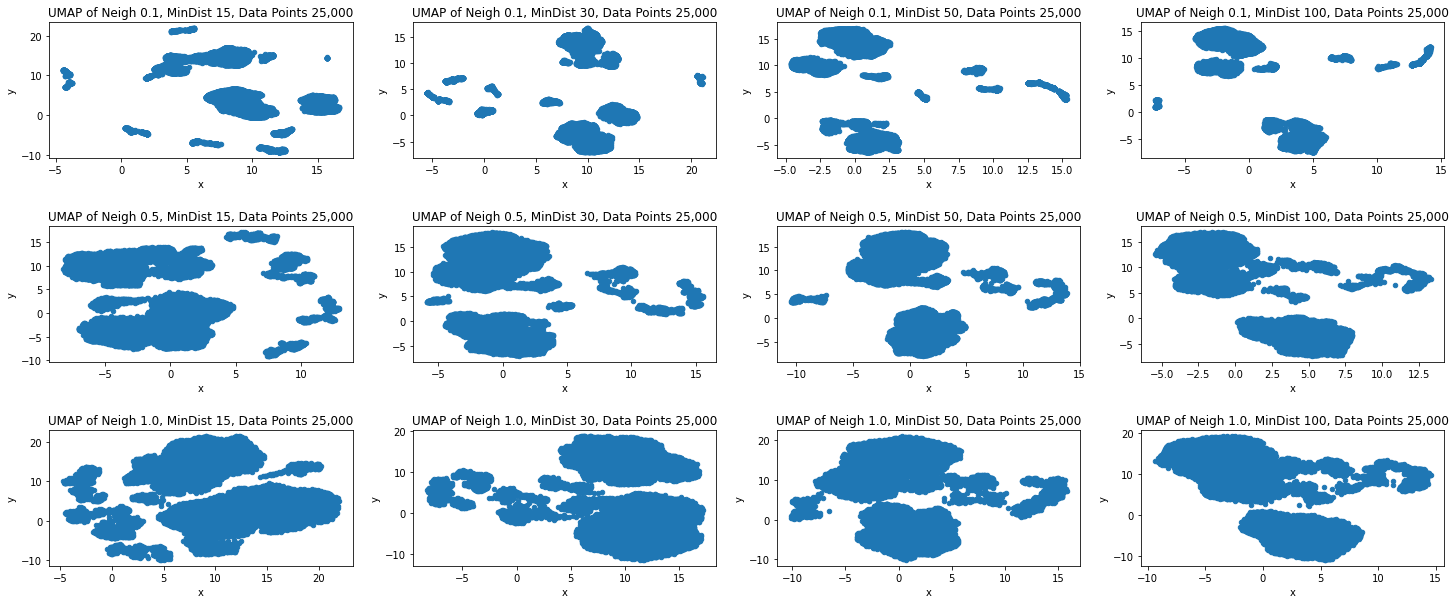

In [16]:
plot_umap(umap_data_dict_=umap_data_dict, data_points=umap_points)

In [42]:
def plot_tsne(tsne_data_dict_, data_points, subplots=3):
    """
    This method creates the TSNE plots at different perplexities
    
    :param tsne_data_dict_: Dictionary contains matrices of  TSNE outputs
    :param subplots: No of subplots to plot. It should match the no. of keys in the tsne_data_dict
    :return: None
    """
    fig, axes = plt.subplots(1, subplots, figsize = (25,8))

    for perp, ax in zip(tsne_data_dict_.keys(), axes):
        pd.DataFrame(tsne_data_dict_[perp][:,:2], columns=['x', 'y']).plot.scatter(x='x', y='y', ax=ax)
        ax.set_title(f"Customer Demographics TSNE of Perplexity {perp}, Data Points {data_points}")
        
    plt.show()

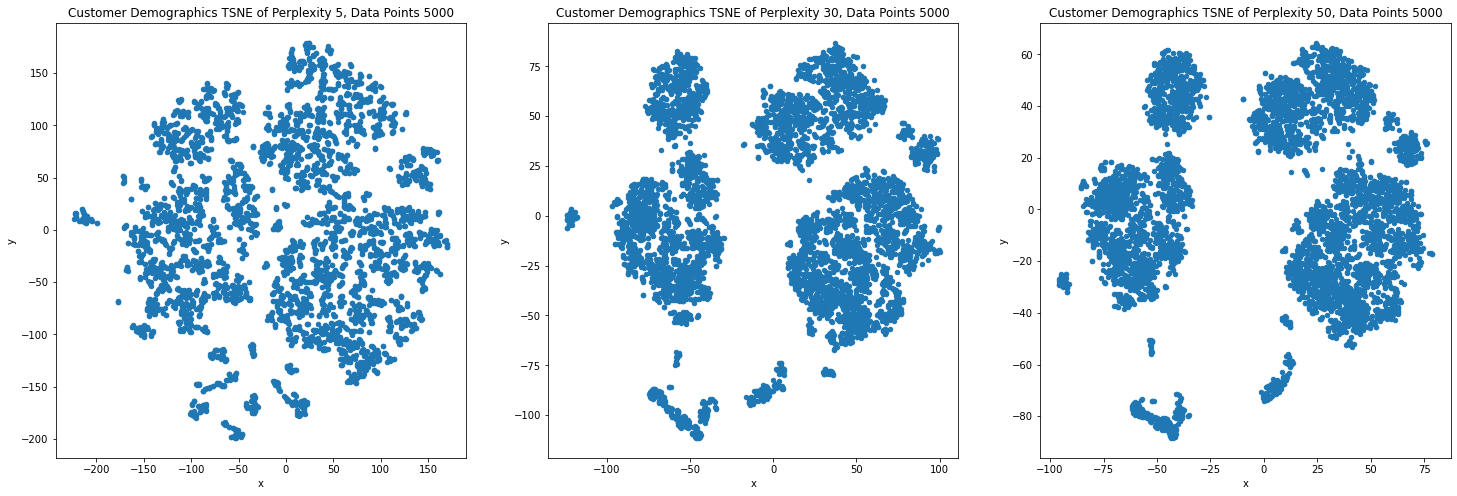

In [43]:
plot_tsne(tsne_data_dict_=tsne_data_dict, data_points=tsne_points)

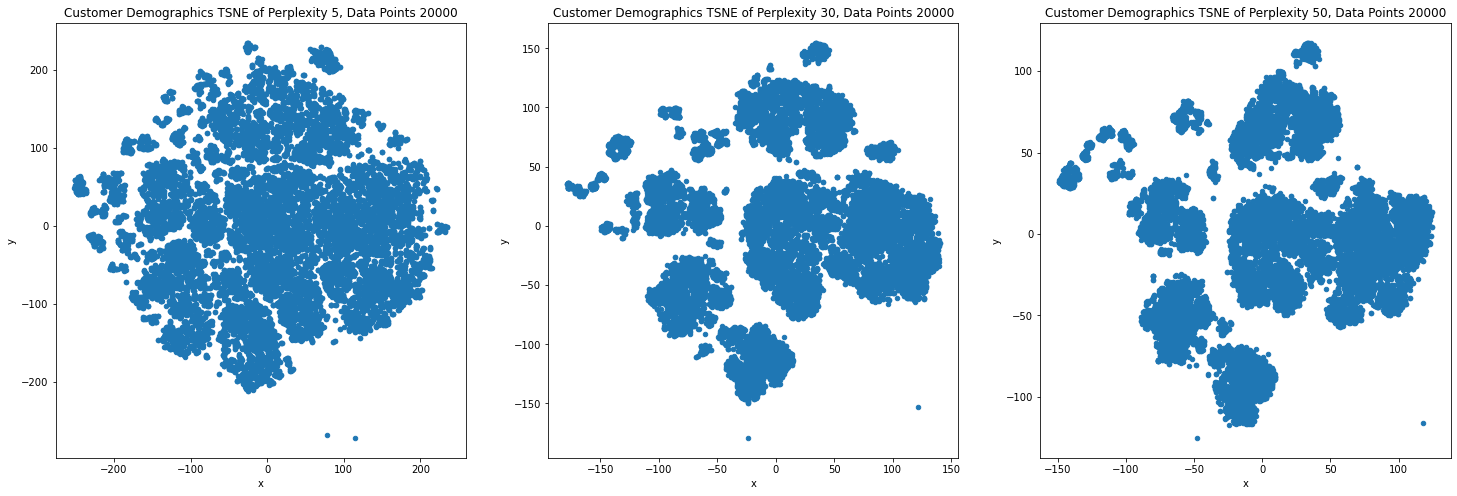

In [57]:
plot_tsne(tsne_data_dict_=tsne_data_dict, data_points=tsne_points)

## Clustering with HDBSCAN

In [ ]:
%%time
# Using datasets with dimensions greater than 2
min_clusters = 500
min_samples = 10

hbdscan_fitted = hdbscan.HDBSCAN(min_cluster_size=min_clusters, min_samples=min_samples, cluster_selection_method='eom', prediction_data=True).fit(cluster_embedding)
print(f"The algorithm has created {max(hbdscan_fitted.labels_)+1} clusters")

In [44]:
%%time
hbdscan_fitted = hdbscan.HDBSCAN(min_cluster_size=25, prediction_data=True).fit(X)
print(f"The algorithm has created {max(hbdscan_fitted.labels_)+1} clusters")

The algorithm has created 6 clusters
Wall time: 3h 47min 43s


3h 47min for All points  
29min for 50k points  
1min for 10k points

In [45]:
with open(processed_dir + 'hbdscan_clusterer_all.pkl', mode='wb+') as fp:
    cPickle.dump(hbdscan_fitted, fp)

In [58]:
with open(processed_dir + f'tsne_data_{tsne_points}.pkl', mode='wb+') as fp:
    cPickle.dump(tsne_data_dict, fp)

In [166]:
%%time
labels = hdbscan.approximate_predict(hbdscan_fitted, embedding)

clusters_tsne_data_dict = dict()
for key in tsne_data_dict.keys():
    clusters_tsne_data_dict[key] = np.concatenate([tsne_data_dict[key][:, :2], labels[0].reshape(-1,1)], axis=1)

Wall time: 153 ms


In [30]:
%%time
labels = hdbscan.approximate_predict(hbdscan_fitted, cluster_embedding[:25_000])

clusters_umap_data_dict = dict()
clusters_umap_data_dict[0] = np.concatenate([umap_data_dict[50, 0.1][:,:2], labels[0].reshape(-1,1)], axis=1)

Wall time: 4.1 s


In [24]:
def plot_clusters(clusters_tsne_data_dict_, points, min_clusters, subplots=3):
    """
    This method plots the identified customer clusters on the TSNE plots
    
    :param clusters_tsne_data_dict_: Dictionary that contains tsne & cluster data
    :param points: No of points that were used to fit the HDBSCAN algorithm
    :param min_clusters: Min no of clusters parameter from HDBSCAN Algorithm
    :param subplots: No of subplots to plot. It should match the no. of keys in the clusters_tsne_data_dict_
    :return: None
    """
    fig, axes = plt.subplots(1, subplots, figsize = (25,8))
    
    if subplots == 1:
        axes = [axes]

    for perp, ax in zip(clusters_tsne_data_dict_.keys(), axes):
        pd.DataFrame(clusters_tsne_data_dict_[perp], columns=['x', 'y', 'cluster']).plot.scatter(x='x', y='y', c='cluster', cmap="Set1", ax=ax)
        ax.set_title(f"TSNE of Perplexity {perp}  & HDBSCAN Min Clusters {min_clusters}, Train Points {points:,}")

    plt.show()

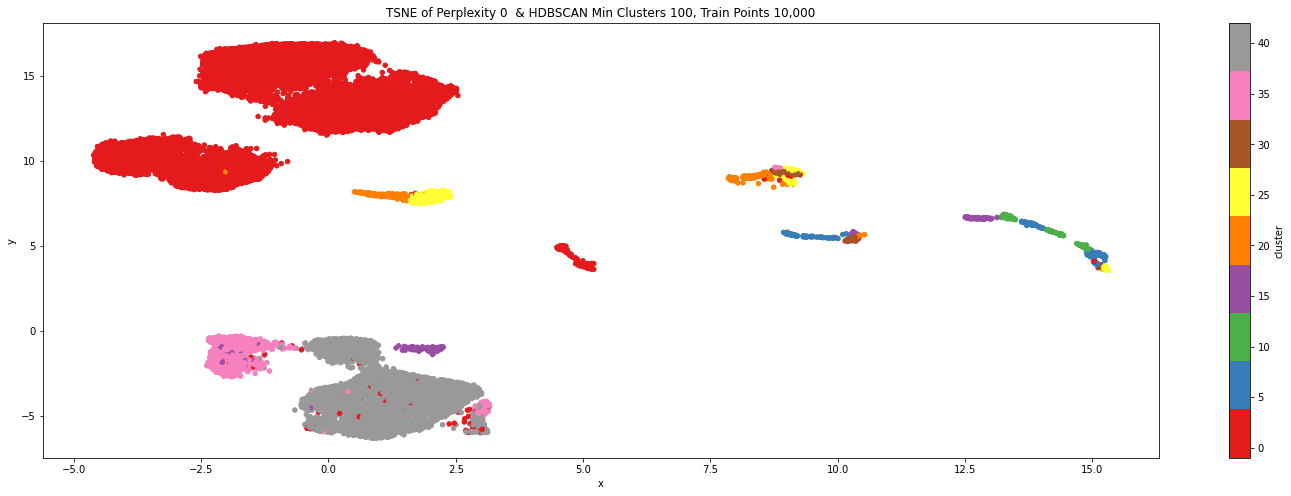

In [31]:
plot_clusters(clusters_tsne_data_dict_=clusters_umap_data_dict, points=cluster_points, min_clusters=min_clusters, subplots=1)

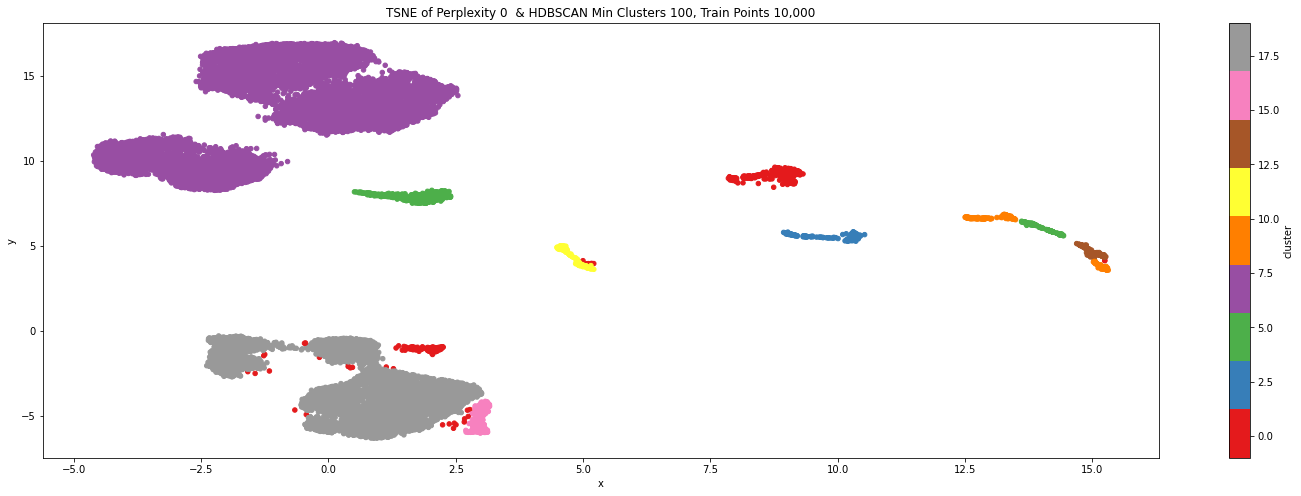

In [25]:
plot_clusters(clusters_tsne_data_dict_=clusters_umap_data_dict, points=cluster_points, min_clusters=min_clusters, subplots=1)

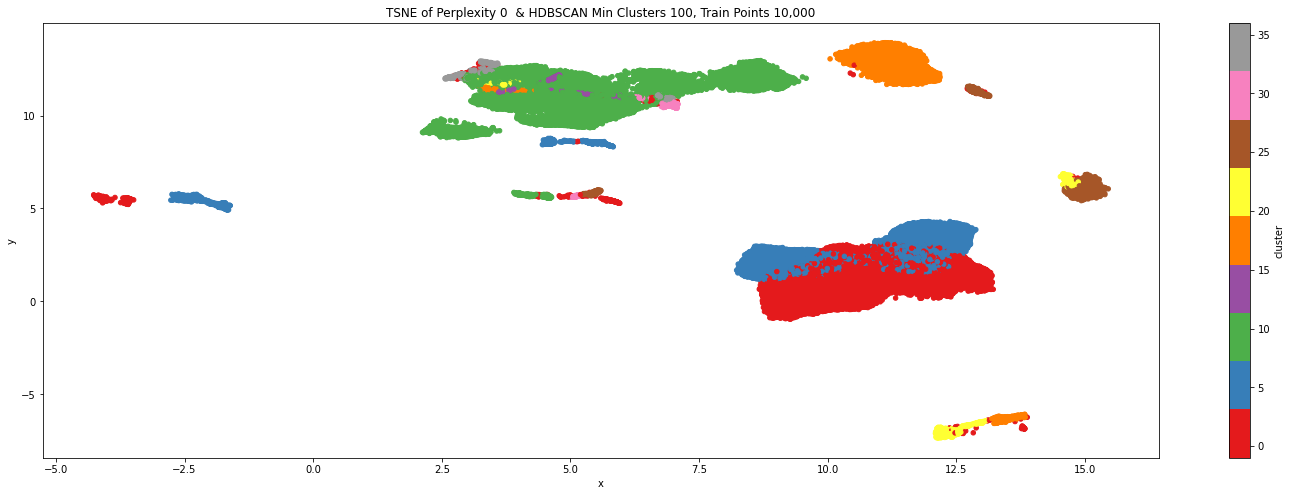

In [23]:
plot_clusters(clusters_tsne_data_dict_=clusters_umap_data_dict, points=cluster_points, min_clusters=min_clusters, subplots=1)

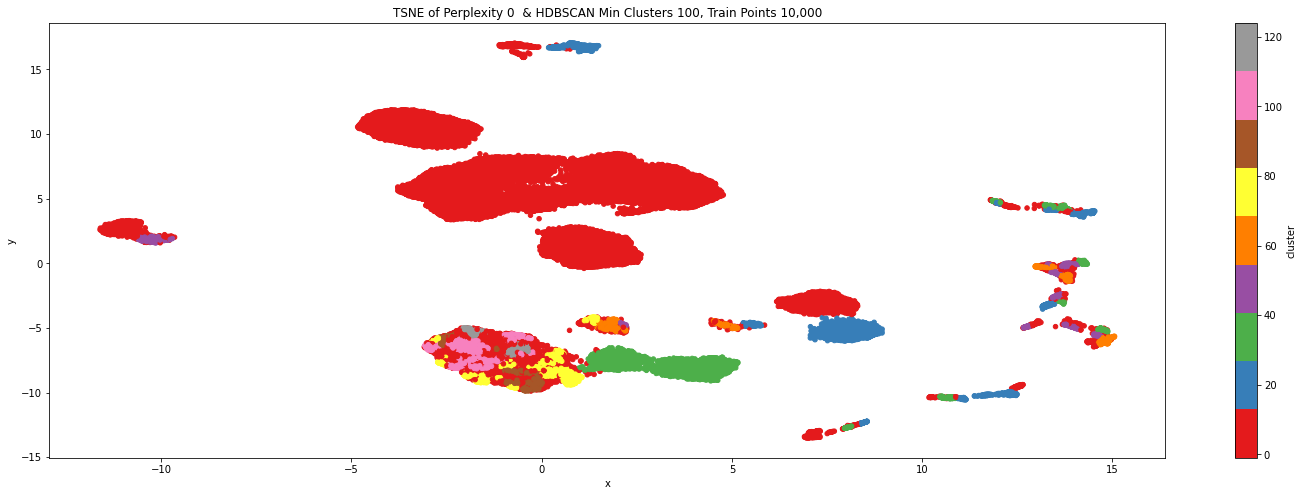

In [211]:
plot_clusters(clusters_tsne_data_dict_=clusters_umap_data_dict, points=cluster_points, min_clusters=min_clusters, subplots=1)

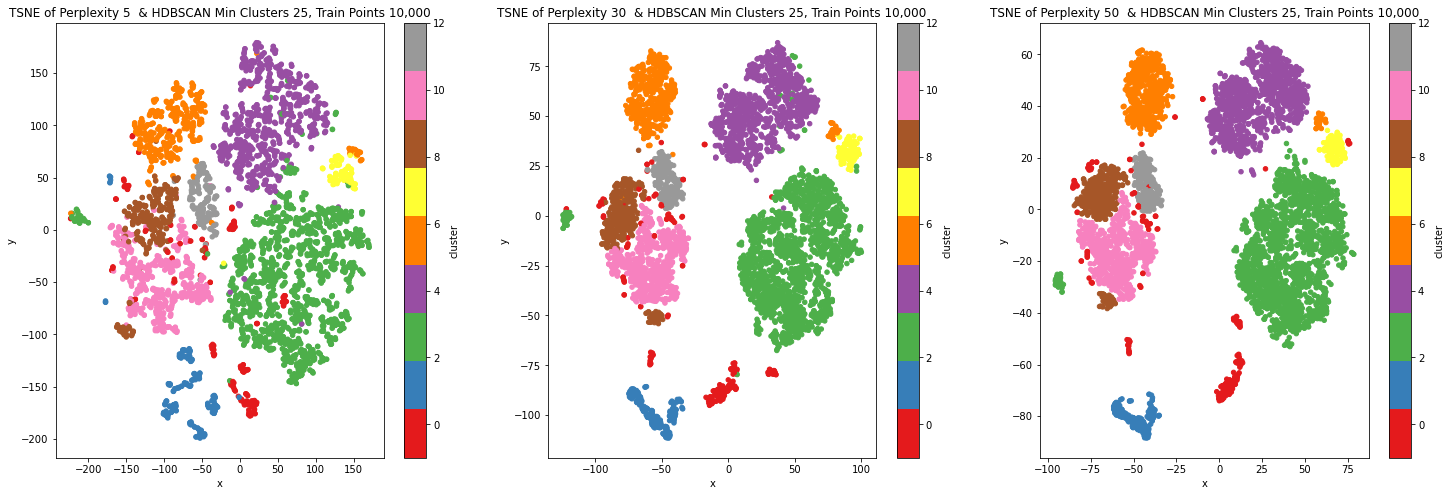

In [167]:
plot_clusters(clusters_tsne_data_dict_=clusters_tsne_data_dict, points=cluster_points, min_clusters=min_clusters)

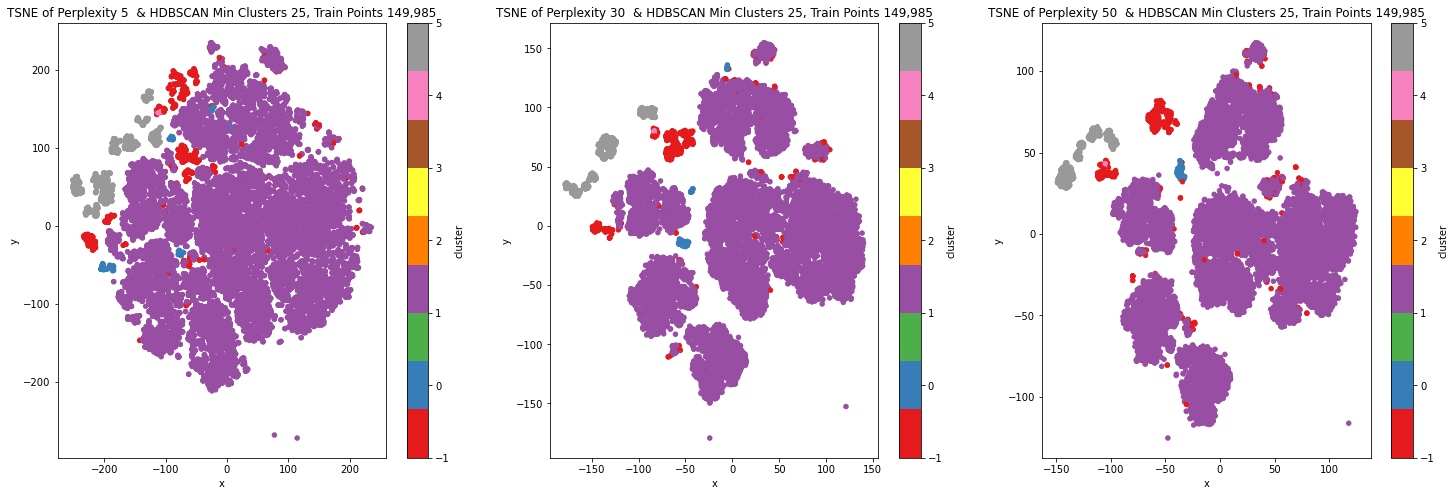

In [61]:
plot_clusters(clusters_tsne_data_dict_=clusters_tsne_data_dict, points=X.shape[0], min_clusters=25)

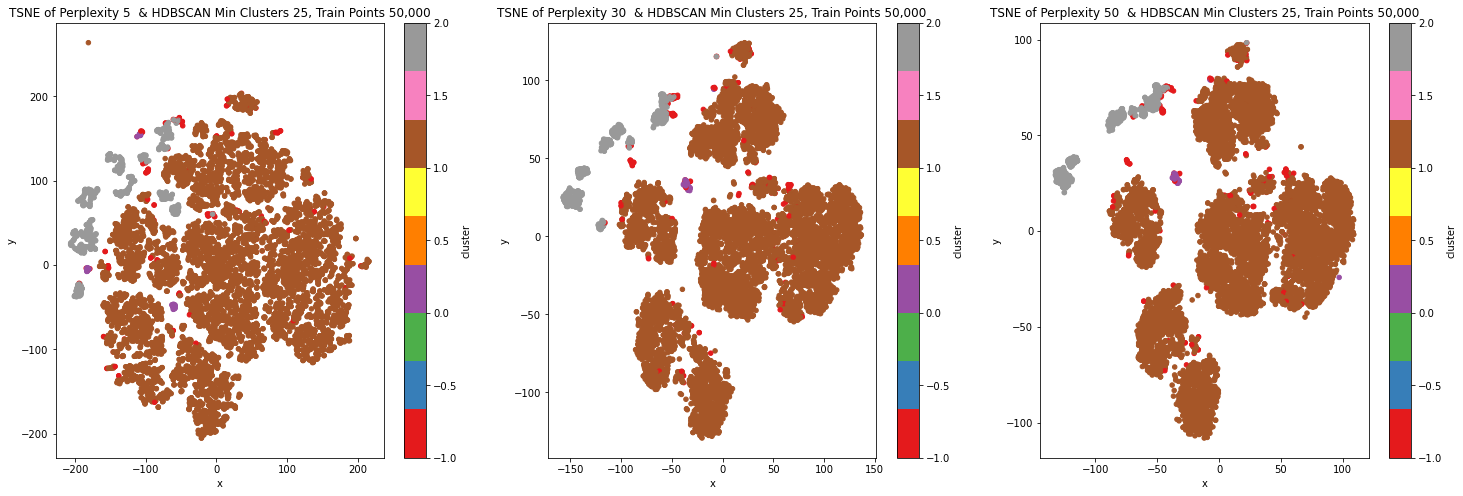

In [ ]:
plot_clusters(clusters_tsne_data_dict_=clusters_tsne_data_dict, points=50_000, min_clusters=25)

# Evaluation

In this section, I analyse the clusters that are identified by the HDBSCAN algorithm.
1. Analyse the created clusters
2. Predict the clusters of the greater population

## Analyse created clusters


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report
import lightgbm as lgb
import seaborn as sns

import shap

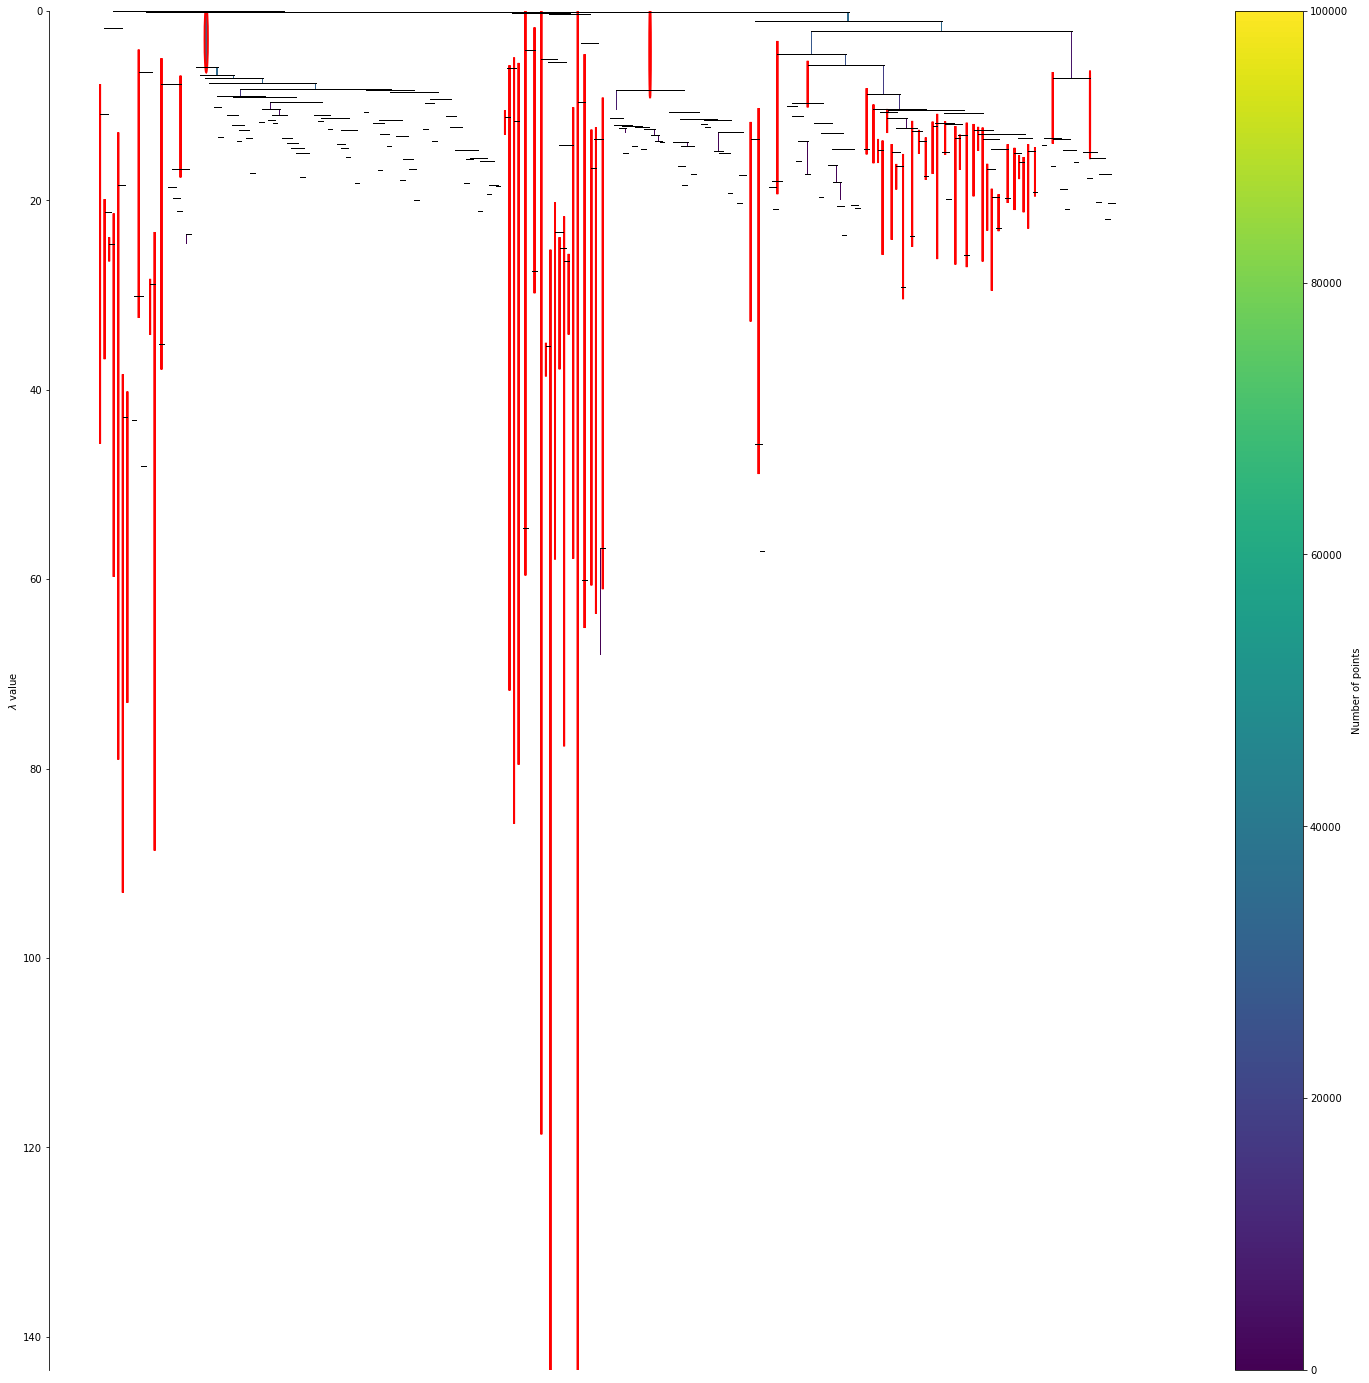

In [50]:
plt.figure(figsize=(25,25))
hbdscan_fitted.condensed_tree_.plot(label_clusters=False, log_size=False, select_clusters=True,selection_palette=sns.color_palette("Set1", 13));

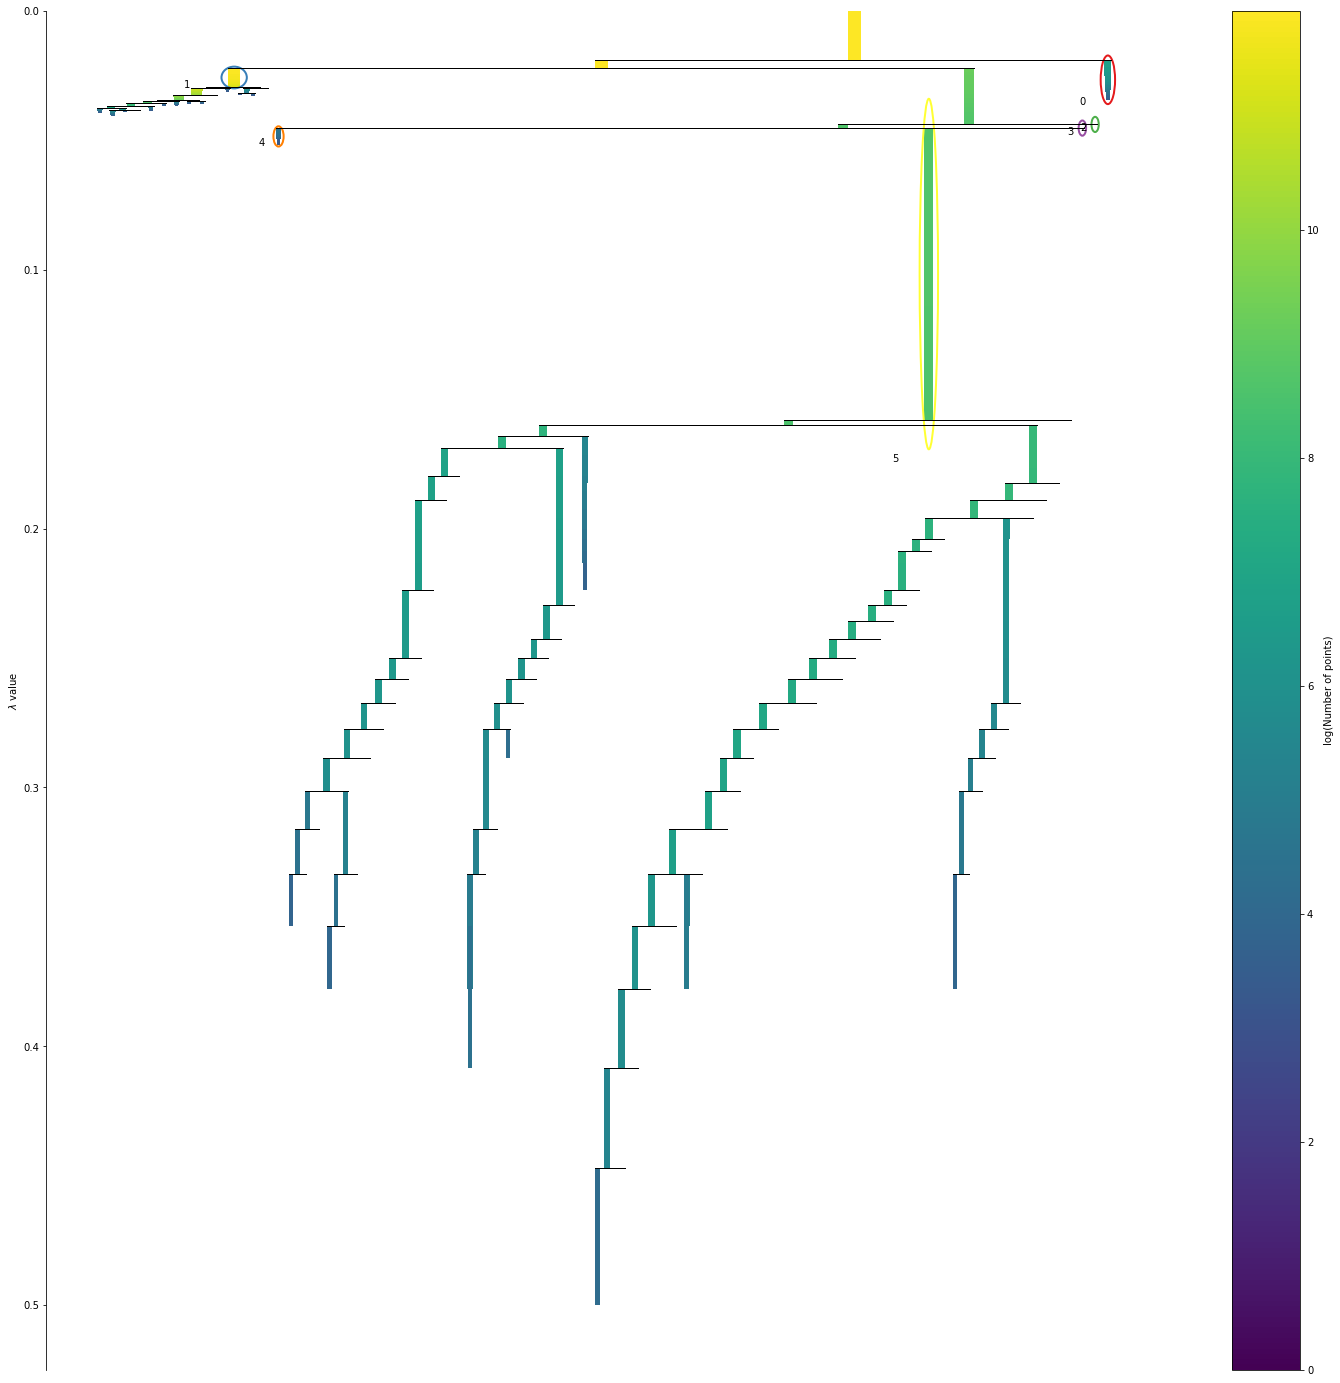

In [49]:
plt.figure(figsize=(25,25))
hbdscan_fitted.condensed_tree_.plot(label_clusters=True, log_size=True, select_clusters=True,selection_palette=sns.color_palette("Set1", 6));

In [51]:
demographics_clean_sample.shape

(100000, 359)

In [62]:
%%time
customer_demographics_clean_sample = customer_demographics_clean.sample(15_000)


customer_cluster_embeddings = umap_fitted.transform(customer_demographics_clean_sample.values)
customer_clusters = hdbscan.approximate_predict(hbdscan_fitted, customer_cluster_embeddings)
customer_demographics_clean_sample['clusters'] = customer_clusters[0]
customer_demographics_clean_sample['clusters_prob'] = customer_clusters[1]


clusters = hdbscan.approximate_predict(hbdscan_fitted, cluster_embedding)
demographics_clean_sample['clusters'] = clusters[0]
demographics_clean_sample['clusters_prob'] = clusters[1]


demographics_clean_sample['Customer'] = 0
customer_demographics_clean_sample['Customer'] = 1

demographics_clean_sample_final = customer_demographics_clean_sample.append(demographics_clean_sample)

In [63]:
cluster_labels = demographics_clean_sample_final.clusters.unique()

total_records = demographics_clean_sample_final.shape[0]
customer_prop = demographics_clean_sample_final.Customer.mean()
cust_count_full = demographics_clean_sample_final.Customer.sum()
analysis_df = pd.DataFrame({'Cluster': ['All'], 'Not Customer': [(1-customer_prop)*100], 'Customer': [customer_prop*100], 'Per_Share_Customers': [cust_count_full*100/cust_count_full]})

for cluster_ in cluster_labels:
    customer_prop = demographics_clean_sample_final.query("clusters == @cluster_").Customer.mean()
    cust_count = demographics_clean_sample_final.query("clusters == @cluster_").Customer.sum()    
    analysis_df = analysis_df.append({'Cluster': cluster_, 'Not Customer': (1-customer_prop)*100, 'Customer': customer_prop*100, 'Per_Share_Customers': cust_count*100/cust_count_full}, ignore_index=True)

analysis_df.sort_values(by=['Customer'], ascending=False)

,Cluster,Not Customer,Customer,Per_Share_Customers
5,31,68.345027,31.654973,10.226667
7,4,68.693402,31.306598,1.613333
31,17,69.354839,30.645161,0.380000
10,32,69.595910,30.404090,8.326667
1,19,70.916335,29.083665,0.973333
...,...,...,...,...
65,45,100.000000,0.000000,0.000000
66,57,100.000000,0.000000,0.000000
67,66,100.000000,0.000000,0.000000
68,46,100.000000,0.000000,0.000000


In [65]:
analysis_df.sort_values(by=['Customer'], ascending=False).head(20)

,Cluster,Not Customer,Customer,Per_Share_Customers
5,31,68.345027,31.654973,10.226667
7,4,68.693402,31.306598,1.613333
31,17,69.354839,30.645161,0.380000
10,32,69.595910,30.404090,8.326667
1,19,70.916335,29.083665,0.973333
2,2,72.520197,27.479803,43.993333
15,10,75.420875,24.579125,0.486667
18,60,83.227848,16.772152,0.353333
26,9,83.555556,16.444444,0.246667
23,14,83.860414,16.139586,0.986667


In [32]:
def analyse_clusters(pred_cluster):
    """
    This method performs a simple and quick analysis of the predicted clusters
    """
    fig, axes = plt.subplots(1,2, figsize = (14,5))
    titles = ['s', ' Probabilites']
    for train_vals, ax, ttl in zip(pred_cluster, axes, titles):
        ax.hist(train_vals)
        ax.set_title(f"Histogram of Cluster{ttl}")

    print('Cluster Value Count\n', pd.Series(pred_cluster[0]).value_counts())

    plt.show()

Cluster Value Count
  1    90464
 2     6699
 0     1522
-1     1315
dtype: int64


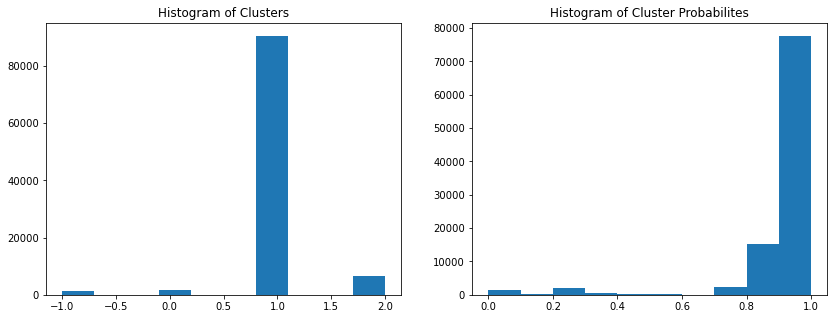

In [135]:
analyse_clusters(clusters)

In [89]:
customer_demographics_clean.to_csv(processed_dir + "customer_demographics_clean.csv", index=False)

In [3]:
customer_demographics_clean = pd.read_csv(processed_dir + "customer_demographics_clean.csv")

Next, we train an inferential classification model. We then use SHAP to understand the most important features for each of the 6 clusters.

In [4]:
random_seed = 22
all_columns = customer_demographics_clean.drop(columns=['clusters', 'clusters_prob']).columns.tolist()
non_categ_features = 'ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW'.split(',')
categ_features = [col for col in all_columns if col not in non_categ_features]

In [5]:
%%time
# Build Inferential Model to explain created Clusters
X_train, X_test, y_train, y_test = train_test_split(customer_demographics_clean.drop(columns=['clusters', 'clusters_prob']), customer_demographics_clean['clusters'], test_size=0.33, random_state=random_seed)

# Train and Predict 
lgbm = lgb.LGBMClassifier(random_state=random_seed, learning_rate=0.01, n_estimators=100, n_jobs=-1, verbose=1, objective='multiclass')\
    .fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss', early_stopping_rounds=20, feature_name=all_columns, categorical_feature=categ_features)
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['AGER_TYP', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score -3.336923
[LightGBM] [Info] Start training from score -5.224384
[LightGBM] [Info] Start training from score -0.081651
[LightGBM] [Info] Start training from score -8.684590
[LightGBM] [Info] Start training from score -8.809753
[LightGBM] [Info] Start training from score -7.135777
[LightGBM] [Info] Start training from score -3.314226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.325489
[2]	valid_0's multi_logloss: 0.305313
[3]	valid_0's multi_logloss: 0.289196
[4]	valid_0's multi_logloss: 0.27569
[5]	valid_0's multi_logloss: 0.264022
[6]	valid_0's multi_logloss: 0.253739
[7]	valid_0's multi_

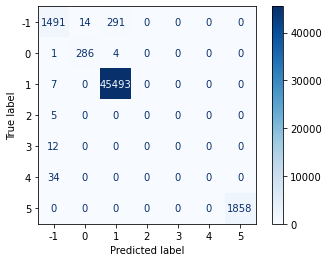

In [51]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(-1,6))
disp.plot(cmap="Blues", values_format='');

In [55]:
print("Classification report for Inferential Model")
print(classification_report(y_test, y_pred, digits=3))

Classification report for Inferential Model
              precision    recall  f1-score   support

          -1      0.962     0.830     0.891      1796
           0      0.953     0.983     0.968       291
           1      0.994     1.000     0.997     45500
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000        12
           4      0.000     0.000     0.000        34
           5      1.000     1.000     1.000      1858

    accuracy                          0.993     49496
   macro avg      0.558     0.545     0.551     49496
weighted avg      0.991     0.993     0.992     49496



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [7]:
shap.initjs()

In [57]:
%%time
# Explain Model using Shap
max_data_points = 50_000

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[:max_data_points])

Wall time: 43.3 s


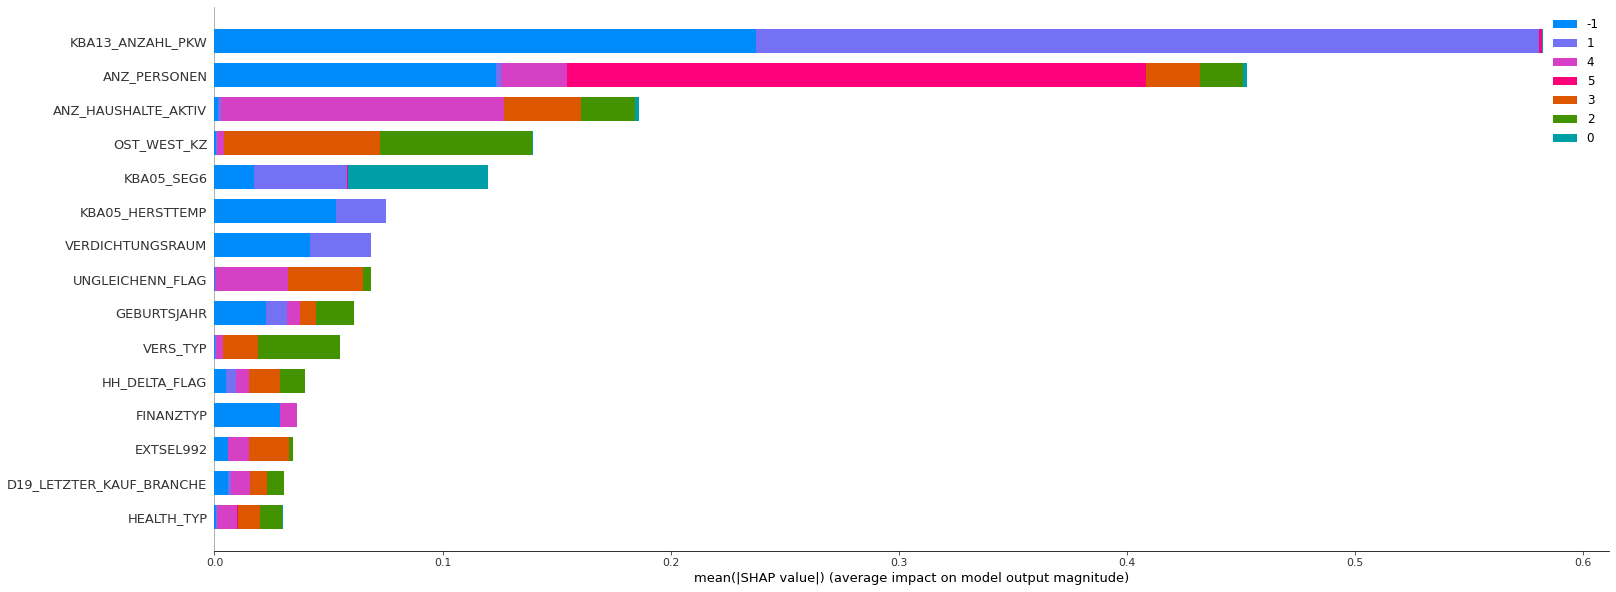

In [93]:
# Plot Summary Plot
shap.summary_plot(shap_values, X_train[:max_data_points], class_names=np.arange(-1,6), plot_type='bar', max_display=15, plot_size=(25, 10), feature_names=all_columns)

In [ ]:
# Plot Summary Plot
def plot_cluster_summary_plot(cluster_no, no_of_features=5, plot_type='bar', shap_values=shap_values, X_train=X_train, max_data_points=max_data_points, all_columns=all_columns):
    """
    This method ..
    
    :param cluster_no:
    :param no_of_features:
    :param plot_type:
    :param shap_values:
    :param X_train:
    :param max_data_points:
    :param all_columns:
    :return: None
    """ 
    fig, axes = plt.subplots(1,1, figsize=(5, 5))

    shap.summary_plot(shap_values[cluster_no], X_train[:max_data_points], plot_type=plot_type, show=False, max_display=no_of_features, plot_size=(10, 5), feature_names=all_columns)
    axes.set_title(f"Cluster {np.arange(-1,6)[cluster_no]} Summary Plot")
    plt.show()

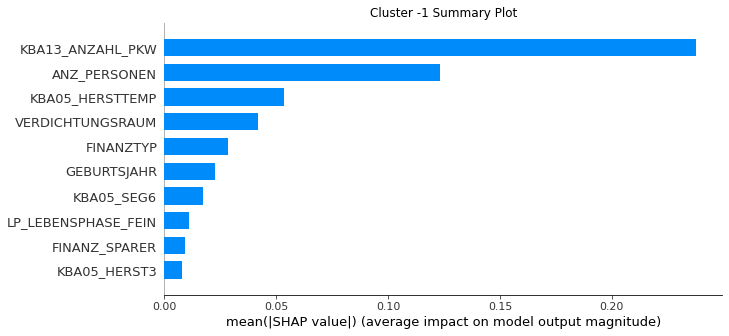

In [110]:
plot_cluster_summary_plot(0, no_of_features=10)

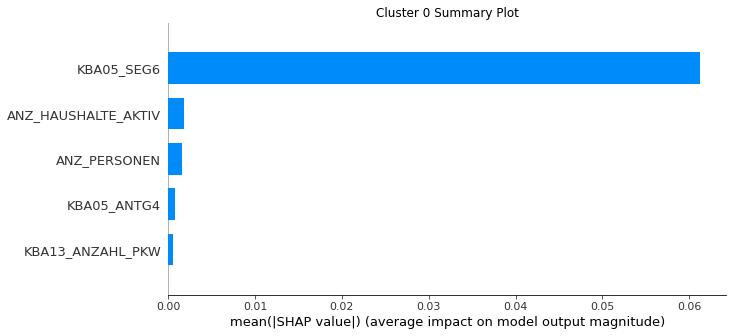

In [104]:
plot_cluster_summary_plot(1)

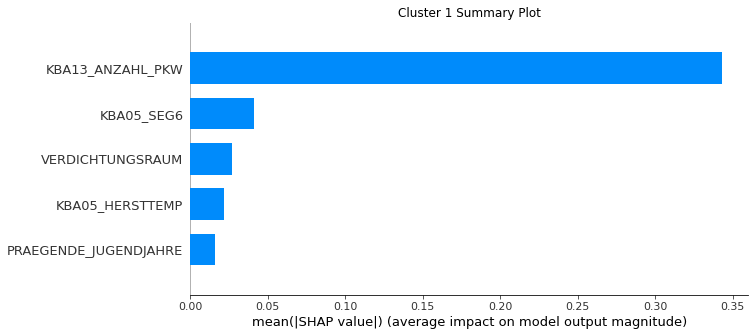

In [105]:
plot_cluster_summary_plot(2)

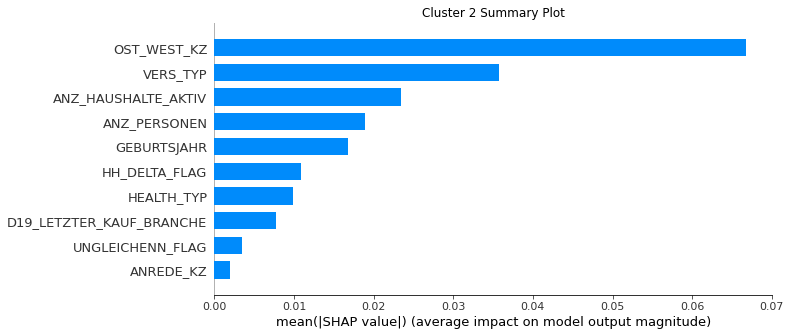

In [111]:
plot_cluster_summary_plot(3, no_of_features=10)

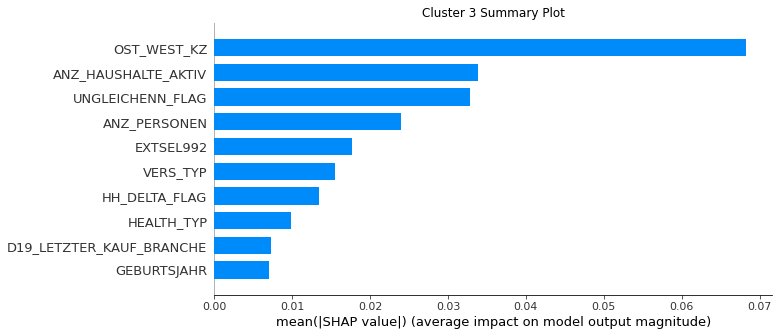

In [112]:
plot_cluster_summary_plot(4, no_of_features=10)

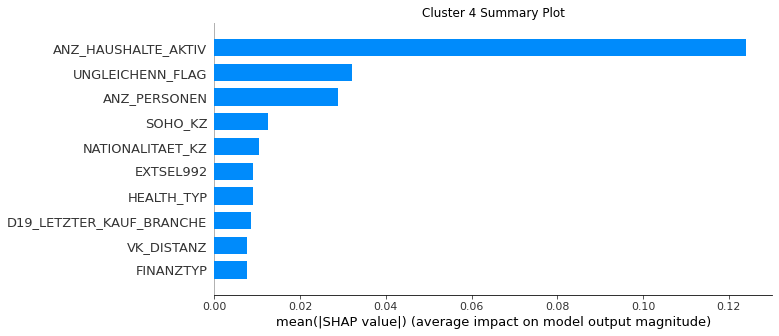

In [113]:
plot_cluster_summary_plot(5, no_of_features=10)

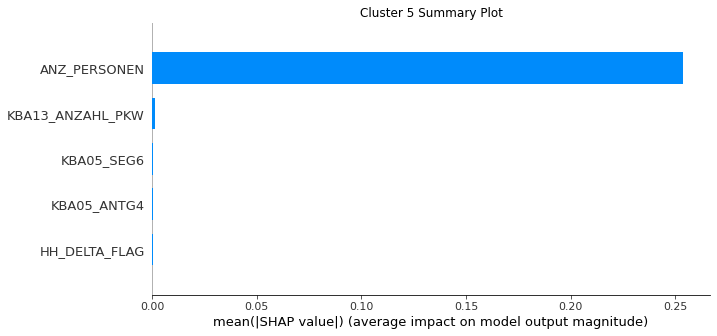

In [109]:
plot_cluster_summary_plot(6)

Comments:
- Weighted Average performance of the inferential model is 99.2% F1-score. So it's is can give reliable insights on the large clusters i.e. **Cluster 1,5 and 0** and the Noise
- Large Clusters:
    - Cluster 1: Based on KBA13_ANZAHL_PKW, high/low number of cars in the PLZ8
    - Cluster 5: Based on ANZ_PERSONEN, high/low number of people in the household.
    - Cluster 0: Based on KBA05_SEG6, high/low no of upperclass cars in microcell
- Noise: No clear dominant feature in this cluster.
- Not Important:
    - Cluster 4: Based on ANZ_HAUSHALTE_AKTIV, no of households in this building
    - Cluster 3 & 2: Top feature is the same for both. OST_WEST_KZ i.e Flag indicating formerly in West/East Germany

## Predict Clusters for Population

In [15]:
with open(processed_dir + 'hbdscan_clusterer_all.pkl', mode='rb+') as fp:
    hbdscan_fitted = cPickle.load(fp)

In [ ]:
%%time
pop_clusters = hdbscan.approximate_predict(hbdscan_fitted, population_demographics_clean.values)

In [ ]:
analyse_clusters(pop_clusters)

In [ ]:
population_demographics_clean['clusters'] = pop_clusters[0]
population_demographics_clean['clusters_prob'] = pop_clusters[1]

In [ ]:
population_demographics_clean.to_csv(processed_dir + "population_demographics_clean.csv", index=False)

Comments  
- sds